In [1]:
import mne
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def readRegMatrix(trsfPath):
	with open(trsfPath) as (f):
		return np.loadtxt(f.readlines())

In [13]:

def imshow_mri(data, img, vox, suptitle, cmap='gray', vmin=None, vmax=None):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots()
    codes = nb.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    scale = np.max(data.shape[2]/data.shape[1])
    ax.imshow(data[i], cmap=cmap, origin='lower', aspect=scale*0.8, vmin=vmin, vmax=vmax)
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig



## Original T1w

In [14]:
t1_obj1 = nb.load('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_acq-noncontrast_T1w.nii.gz')
mgh = nb.MGHImage(t1_obj1.dataobj, t1_obj1.affine)
Torig1 = mgh.header.get_vox2ras_tkr()
fs_transform = np.dot(t1_obj1.affine, np.linalg.inv(Torig1))

In [15]:
data1 = np.asarray(t1_obj1.dataobj)
data1.shape

(256, 256, 160)

(256, 160, 256)


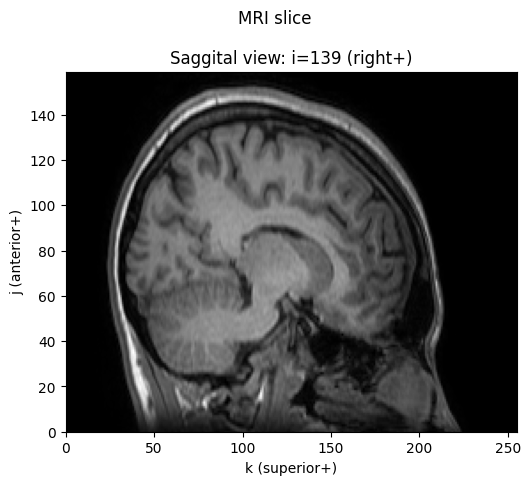

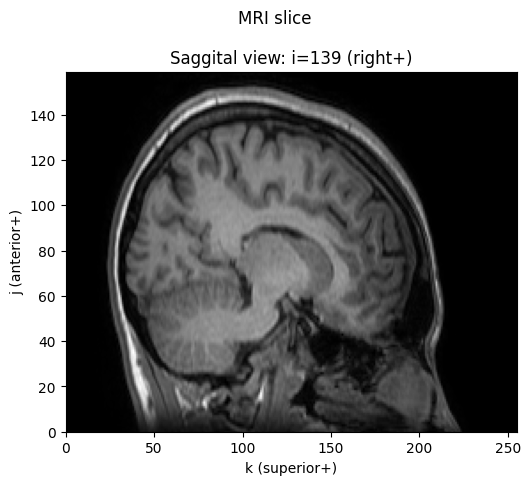

In [16]:
ras_coords_mm = np.array([10, -17, -20])
inv_affine = np.linalg.inv(t1_obj1.affine)
vox1 = np.round(mne.transforms.apply_trans(inv_affine, ras_coords_mm)).astype(int)
dataplot = np.swapaxes(data1, 1, 2)
print(dataplot.shape)
imshow_mri(dataplot, t1_obj1, vox1, 'MRI slice')

In [44]:
mne.transforms.apply_trans(t1_obj1.affine, vox1)

array([  9.7440033 , -17.37800598, -19.90240097])

In [45]:
t1_obj2 = nb.load('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/mri/orig.mgz')
# mgh = nb.MGHImage(t1_obj.dataobj, t1_obj.affine)
Torig2 = t1_obj2.header.get_vox2ras_tkr()
to_MIR_transform = np.dot(t1_obj2.affine, np.linalg.inv(Torig2))

In [46]:
pthlh = 'projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/surf/lh.pial'
verl,facel=nb.freesurfer.read_geometry(pthlh)
pthrh = 'projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/surf/rh.pial'
verr,facer=nb.freesurfer.read_geometry(pthrh)
all_ver = np.concatenate([verl, verr], axis=0)
print(all_ver[5,:])
all_face = np.concatenate([facel, facer+verl.shape[0]], axis=0)
surf_mesh = [all_ver, all_face]
all_ver_shift=(mne.transforms.apply_trans(to_MIR_transform, all_ver))
print(all_ver_shift[5,:])
all_ver_shift = (mne.transforms.apply_trans(inv_affine, all_ver_shift))
print(all_ver_shift[5,:])

[-11.92174435 -89.75159454   2.04344416]
[-13.17774105 -30.12960052  36.14103937]
[116.07825565  38.24840546  82.04344034]


In [47]:
test = [-13.17774105, -30.12960052,  36.14103937]
vox_fs=(mne.transforms.apply_trans(np.linalg.inv(t1_obj2.affine), test))
fs_ras = (mne.transforms.apply_trans(Torig2, vox_fs))
mri_ras = (mne.transforms.apply_trans(to_MIR_transform, fs_ras))
mri_vox = (mne.transforms.apply_trans(inv_affine, mri_ras))
print(mri_vox)
mri_true = (mne.transforms.apply_trans(inv_affine, test))
print(mri_true)

[116.07825565  38.24840546  82.04344034]
[116.07825565  38.24840546  82.04344034]


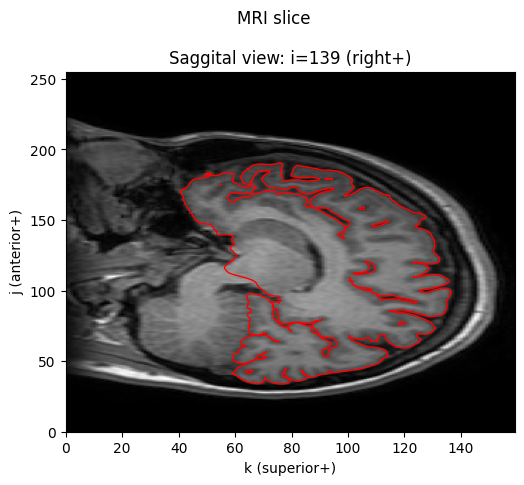

In [48]:
fig = imshow_mri(data1, t1_obj1, vox1, 'MRI slice')
fig.axes[0].tricontour(all_ver_shift[:, 2], all_ver_shift[:, 1], all_face, all_ver_shift[:, 0],
                       levels=[vox1[0]], colors='r', linewidths=1.0,
                       zorder=1)

## Electrode pos and fs file to voxels 

In [17]:
# Load reference MRI (orig.mgz)
t1_obj = nb.load('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/mri/orig.mgz')
Torig = t1_obj.header.get_vox2ras_tkr()
fs_transform = np.dot(t1_obj.affine, np.linalg.inv(Torig)) # To go from fs ras to mri ras

In [18]:
data = np.asarray(t1_obj.dataobj)
data.shape

(256, 256, 256)

In [19]:
# Load electrodes position
elec_pos = pd.read_csv('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P076/sub-P076_space-native_SEEGA.tsv', sep='\t')

In [20]:
elec_pos.head()

,type,label,x,y,z,orig_group,new_label,new_group
0,SEEGA,LACg1,-5.680,62.715,19.892,LACg,LACg1,LACg
1,SEEGA,LACg2,-10.684,63.100,19.846,LACg,LACg2,LACg
2,SEEGA,LACg3,-15.313,63.549,19.846,LACg,LACg3,LACg
3,SEEGA,LACg4,-20.321,63.567,19.207,LACg,LACg4,LACg
4,SEEGA,LACg5,-25.330,63.843,19.207,LACg,LACg5,LACg


In [21]:
mri_ras_mm = elec_pos.loc[elec_pos.label=='LAHc7', ['x', 'y', 'z']].to_numpy()[0]
mri_ras_mm # Electrode position in contrast space!!

array([-48.369,  25.969,  -4.013])

In [22]:
# The transform file goes from contrast to non-contrast. The tfm, when loaded in slicer actually goes
# from non-contrast to contrast but the txt is inversed!
t1_transform=readRegMatrix('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_acq-noncontrast_desc-rigid_from-noncontrast_to-contrast_type-ras_xfm.txt')
# Transform from contrast mri ras to non-contrast MRI ras
mri_ras_mm = mne.transforms.apply_trans(t1_transform, mri_ras_mm)
mri_ras_mm

array([-46.96182096,  64.30931775,  10.30883635])

In [23]:
inv_affine = np.linalg.inv(t1_obj.affine)
# here's where the interpolation should be performed!!
vox = np.round(mne.transforms.apply_trans(inv_affine, mri_ras_mm)).astype(int)
vox

array([174, 152, 133])

In [24]:
mne.transforms.apply_trans(t1_obj.header.get_vox2ras(), vox)

array([-47.2559967 ,  64.62199402,  10.09759521])

In [25]:
pthlh = 'projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/surf/lh.pial'
verl,facel=nb.freesurfer.read_geometry(pthlh)
pthrh = 'projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/surf/rh.pial'
verr,facer=nb.freesurfer.read_geometry(pthrh)
all_ver = np.concatenate([verl, verr], axis=0)
all_face = np.concatenate([facel, facer+verl.shape[0]], axis=0)
surf_mesh = [all_ver, all_face]
all_ver_shift=(mne.transforms.apply_trans(np.linalg.inv(Torig), all_ver))

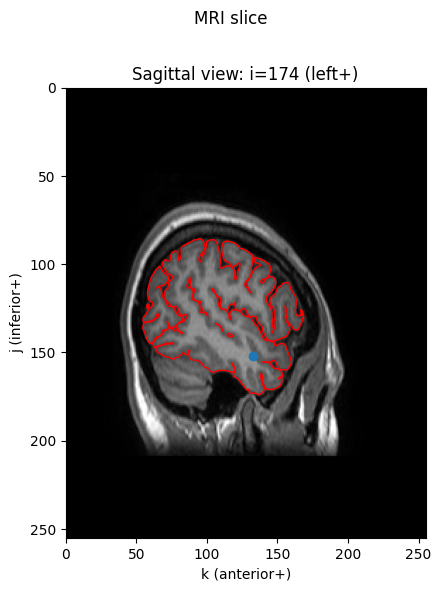

In [26]:
fig = imshow_mri(data, t1_obj, vox, 'MRI slice')
fig.axes[0].tricontour(all_ver_shift[:, 2], all_ver_shift[:, 1], all_face, all_ver_shift[:, 0],
                       levels=[vox[0]], colors='r', linewidths=1.0,
                       zorder=1)
fig.axes[0].scatter(vox[2], vox[1])

## Parcellation with electrodes

In [4]:
# Load parcellation file
parc_obj = nb.load('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/mri/aparc+aseg.orig.mgz')
Torig_parc = parc_obj.header.get_vox2ras_tkr()
fs_transform_parc = np.dot(parc_obj.affine, np.linalg.inv(Torig_parc)) # To go from fs ras to mri ras

In [5]:
data_parc = np.asarray(parc_obj.dataobj)
data_parc.shape

(256, 256, 256)

In [6]:
# Load electrodes position
elec_df = pd.read_csv('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P076/sub-P076_space-native_SEEGA.tsv', sep='\t')

In [7]:
mri_ras_mm = elec_df.loc[elec_df.label=='LAHc7', ['x', 'y', 'z']].to_numpy()[0]
mri_ras_mm # Electrode position in contrast space!!

array([-48.369,  25.969,  -4.013])

In [8]:
# The transform file goes from contrast to non-contrast. The tfm, when loaded in slicer actually goes
# from non-contrast to contrast but the txt is inversed!
t1_transform=readRegMatrix('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_acq-noncontrast_desc-rigid_from-noncontrast_to-contrast_type-ras_xfm.txt')
# Transform from contrast mri ras to non-contrast MRI ras
mri_ras_mm = mne.transforms.apply_trans(t1_transform, mri_ras_mm)
mri_ras_mm

array([-46.96182096,  64.30931775,  10.30883635])

In [9]:
inv_affine = np.linalg.inv(parc_obj.affine)
# here's where the interpolation should be performed!!
vox = np.round(mne.transforms.apply_trans(inv_affine, mri_ras_mm)).astype(int)
vox

array([174, 152, 133])

In [12]:
data_parc[vox[0],vox[1],100:110]

array([   2, 1007, 1007, 1007, 1007, 1007, 1009, 1009, 1009,    2],
      dtype=int16)

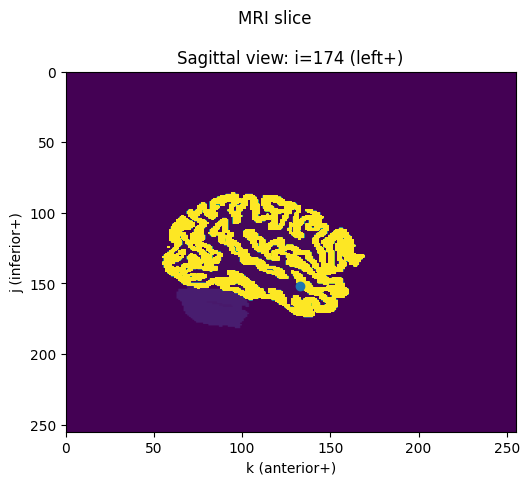

In [19]:
fig = imshow_mri(data_parc, parc_obj, vox, 'MRI slice', cmap='viridis', vmin=0, vmax=100)
fig.axes[0].scatter(vox[2], vox[1])

## Electrode pos to fs ras space

In [ ]:
t1_obj1 = nb.load('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_acq-noncontrast_T1w.nii.gz')
mgh = nb.MGHImage(t1_obj1.dataobj, t1_obj1.affine)
Torig1 = mgh.header.get_vox2ras_tkr()
fs_transform = np.dot(t1_obj1.affine, np.linalg.inv(Torig1))

In [ ]:
# Load electrodes position
elec_pos = pd.read_csv('projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P076/sub-P076_space-native_SEEGA.tsv', sep='\t')